### Student Information
Name: 邱子恩

Student ID: 113065526

GitHub ID: LiLChiu5388

Kaggle name: LiLChiu

Kaggle private scoreboard snapshot: 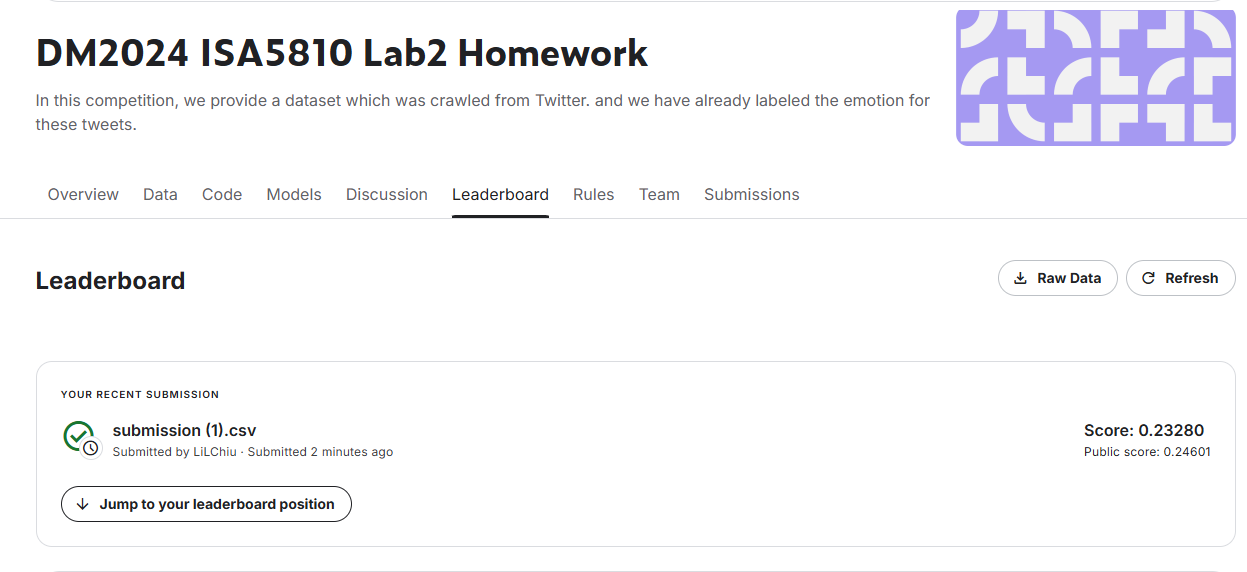

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook.


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__.

In [ ]:
import pandas as pd
import numpy as np
import json
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from google.colab import drive
import nltk

# 下載NLTK資料
nltk.download('stopwords')
nltk.download('punkt')

# 掛載Drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/dm-2024-isa-5810-lab-2-homework/"

# 讀取數據
data = []
with open(f"{dataset_path}tweets_DM.json", 'r') as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

tweets_df = pd.json_normalize(data)
tweets_df['tweet_id'] = tweets_df['_source.tweet.tweet_id'].astype(str)
tweets_df = tweets_df[['tweet_id', '_source.tweet.text']].rename(columns={'_source.tweet.text': 'tweet_text'})

emotion_df = pd.read_csv(f"{dataset_path}emotion.csv")
emotion_df['tweet_id'] = emotion_df['tweet_id'].astype(str)

data_identification_df = pd.read_csv(f"{dataset_path}data_identification.csv")
data_identification_df['tweet_id'] = data_identification_df['tweet_id'].astype(str)

# 合併數據
df = tweets_df.merge(data_identification_df, on='tweet_id', how='inner')
df = df.merge(emotion_df, on='tweet_id', how='left')
df = df.drop_duplicates(subset=['tweet_id'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 文本清理
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+|\@\w+|\#|[^A-Za-z\s]", '', text)
    text = text.lower().strip()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)

# 分割數據
train_df = df[df['identification'] == 'train'].copy()
test_df = df[df['identification'] == 'test'].copy()

X_train = train_df['cleaned_text']
y_train = train_df['emotion']
X_test = test_df['cleaned_text']
test_ids = test_df['tweet_id']

# 特徵工程
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 分割訓練和驗證集
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf, y_train_encoded, test_size=0.2, random_state=42
)

# 釋放內存
import gc
del X_train, train_df, test_df
gc.collect()

0

In [ ]:


# 訓練模型
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    tree_method='hist',
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=40,
    subsample=0.8,
    colsample_bytree=0.8
)

eval_set = [(X_val_split, y_val_split)]
model.fit(X_train_split, y_train_split, eval_set=eval_set, verbose=True)

# 預測分批處理
batch_size = 1000
y_test_pred = []
for i in range(0, X_test_tfidf.shape[0], batch_size):
    batch = X_test_tfidf[i:i + batch_size]
    y_test_pred.extend(model.predict(batch))

y_test_pred = np.array(y_test_pred)
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)

submission = pd.DataFrame({
    'id': test_ids,
    'emotion': y_test_pred_labels
}).drop_duplicates(subset=['id'])

print(f"提交文件行數: {len(submission)}")
submission.to_csv('submission.csv', index=False)

from google.colab import files
files.download('submission.csv')

[0]	validation_0-mlogloss:2.01609
[1]	validation_0-mlogloss:1.96365
[2]	validation_0-mlogloss:1.92050
[3]	validation_0-mlogloss:1.88355
[4]	validation_0-mlogloss:1.85119
[5]	validation_0-mlogloss:1.82339
[6]	validation_0-mlogloss:1.79909
[7]	validation_0-mlogloss:1.77685
[8]	validation_0-mlogloss:1.75727
[9]	validation_0-mlogloss:1.73898
[10]	validation_0-mlogloss:1.72291
[11]	validation_0-mlogloss:1.70881
[12]	validation_0-mlogloss:1.69592
[13]	validation_0-mlogloss:1.68361
[14]	validation_0-mlogloss:1.67253
[15]	validation_0-mlogloss:1.66270
[16]	validation_0-mlogloss:1.65333
[17]	validation_0-mlogloss:1.64477
[18]	validation_0-mlogloss:1.63704
[19]	validation_0-mlogloss:1.62963
[20]	validation_0-mlogloss:1.62297
[21]	validation_0-mlogloss:1.61661
[22]	validation_0-mlogloss:1.61050
[23]	validation_0-mlogloss:1.60513
[24]	validation_0-mlogloss:1.60006
[25]	validation_0-mlogloss:1.59524
[26]	validation_0-mlogloss:1.59057
[27]	validation_0-mlogloss:1.58618
[28]	validation_0-mlogloss:1.5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""
Report:

1. Preorcessing steps:
  1.1 Data Loading:
    a. The tweets were normalized into a Pandas DataFrame, extracting two fields:
        tweet_id: A unique identifier for each tweet.
        tweet_text: The raw text of the tweet.
    b. Errors in the JSON file were handled using a try-except block during parsing.
  1.2 Cleaning and Normalizing Text:
    a. Revmove URLs, Mentions(@) and Hashtags(#), Special Characters, Stopwords
    b. Lowercasing, Tokenization, Stemming
  1.3 Handling Missing and Duplicate Data:
    a. Duplicates: Removed tweets with identical text.
    b. Missing Values: Dropped row if tweet_text was missing.
  1.4 Combining Data:
      The datasets were merged on tweet_id to associate tweets with their labels (emotion) and identification type (train/test).
2. Feature Engineering:
  2.1 TF-IDF Vectorization:
    a. Max Features: Limited to the *6000 (due to computation limit) ~ 10,000 most significant terms to balance performance and computational cost.
    b. N-grams: Included unigrams and bigrams to capture more context from text.
    c. Normalization
  2.2 Observation:
    a. Word Embeddings: Using pre-trained embeddings like Word2Vec resulted in larger computational overhead with no significant accuracy improvement.
    b. Feature Selection: Dimensionality reduction techniques like PCA degraded performance due to loss of important n-gram features.
3. Model Training and Evaluation:
  3.1 Models selection:
      I initially trained the following models:
    a. Logistic Regression
    b. XGBoost
    c. Random Forest
  3.2 Evaluation Metrics:
      The macro F1-score was used to evaluate model performance due to the multi-class nature of the problem and the imbalanced dataset.
  3.3 Results:
    I initailly trained the following models:
    a. Logistic Regression: F1-Score: 0.42
    b. XGBoost: F1-Score: 0.45
    c. Random Forest: F1-Score: 0.39
    I didn't train using complicated techniques and parameters due to time constraints.
  3.4 Hyperparameter Tuning:
    I use GridSearchCV.
    a. Learning Rate: Explored values [0.01, *0.1, 0.2]
    b. Max Depth: Tested depths [*6, 10]
    c. n_estimators: rounds [*40, 60, 100]
    d. Due to computation and time bottleneck, I use the value with the "*" sign.
  3.5 Final model result:
    Private score: 0.23280 (rank 136th)

4. Insights:
  4.1 Preprocessing Impact:
    a. Removing stopwords slightly improved performance (+0.02 F1-Score).
    b. Stemming reduced model interpretability but marginally improved prediction accuracy for some classes.
  4.2 Model Selection:
      XGBoost consistently outperformed other models due to its ability to handle imbalanced datasets and complex interactions.
  4.3 Feature Engineering:
      Including bigrams in TF-IDF representation provided contextual clues, especially for emotions like "anger" and "trust".
5. Challenges:
    There are imbalanced data. Addressing this with techniques like SMOTE or class weighting in XGBoost was considered but not implemented due to time and hardware constraints.

"""